## Baseline Model

#### 1.1 Environment Check

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [14]:
# reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device selection: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'PyTorch version : {torch.__version__}')
print(f'Device          : {device}')
if device.type == 'cuda':
    print(f'GPU             : {torch.cuda.get_device_name(0)}')
    print(f'VRAM            : {torch.cuda.get_device_properties(0).total_mem / 1e9:.1f} GB')

PyTorch version : 2.5.1
Device          : mps


#### 1.2 The Subset

In [15]:
def get_cifar10_loaders(batch_size=64):
    # Standard transformation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load the full training and test datasets
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Create DataLoaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_set.classes

In [16]:
train_loader, val_loader, classes = get_cifar10_subsets()

print(f'Training samples   : {len(train_loader.dataset)}')
print(f'Validation samples : {len(val_loader.dataset)}')
print(f'Classes            : {classes}')
print(f'Batch size         : {train_loader.batch_size}')

# quick sanity peek
imgs, labels = next(iter(train_loader))
print(f'Batch shape        : {imgs.shape}')  # [64, 3, 32, 32]

Files already downloaded and verified


/Users/pranayvishwakarma/Desktop/CIFAR-10-subset-CNN-experiments/venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Files already downloaded and verified
Training samples   : 5000
Validation samples : 1000
Classes            : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Batch size         : 64
Batch shape        : torch.Size([64, 3, 32, 32])


### 1.3 The Evaluation Suite

In [17]:
def count_parameters(model):
    """Return total number of trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    """Compute average loss and accuracy on a dataloader."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                device, epochs=15):
    """
    Standard training loop. Returns history dict with per‑epoch metrics.
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [],   'val_acc': []
    }
    best_val_acc = 0.0
    best_weights = None

    for epoch in range(1, epochs + 1):
        # --- train ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc  = 100.0 * correct / total

        # --- validate ---
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # record
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # checkpoint best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch:3d}/{epochs}  |  '
              f'Train Loss: {train_loss:.4f}  Acc: {train_acc:.2f}%  |  '
              f'Val Loss: {val_loss:.4f}  Acc: {val_acc:.2f}%')

    # restore best weights
    if best_weights:
        model.load_state_dict(best_weights)
    print(f'\nBest validation accuracy: {best_val_acc:.2f}%')
    return history

In [20]:
def plot_history(history, title='Training History'):
    """Plot loss and accuracy curves side by side."""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- loss ---
    ax1.plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'],   's-', label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} — Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- accuracy ---
    ax2.plot(epochs, history['train_acc'], 'o-', label='Train Acc')
    ax2.plot(epochs, history['val_acc'],   's-', label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} — Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

#### 2.1 Build Model 0 — Simple 2‑Layer CNN

In [21]:
class SimpleCNN(nn.Module):
    """
    Model 0: minimal 2-layer CNN.
    Architecture:
        Conv2d(3 -> 16, 3x3) -> ReLU -> MaxPool(2)
        Conv2d(16 -> 32, 3x3) -> ReLU -> MaxPool(2)
        Flatten -> FC(32*8*8 -> 128) -> ReLU -> FC(128 -> 10)
    """

    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),   # 32x32 -> 32x32
            nn.ReLU(),
            nn.MaxPool2d(2),                               # 32x32 -> 16x16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 16x16 -> 16x16
            nn.ReLU(),
            nn.MaxPool2d(2),                               # 16x16 -> 8x8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [22]:
model = SimpleCNN().to(device)
print(model)
print(f'\nTrainable parameters: {count_parameters(model):,}')

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

Trainable parameters: 268,650


### 2.2 Establish Benchmarks — Train for 15 Epochs

In [23]:
EPOCHS = 15 # complete pass through your entire training dataset
LR = 1e-3   # Learning Rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(f'Optimizer : Adam (lr={LR})')
print(f'Loss fn   : CrossEntropyLoss')
print(f'Epochs    : {EPOCHS}')
print(f'Device    : {device}')
print('-' * 65)

start = time.time()
history = train_model(model, train_loader, val_loader, criterion,
                      optimizer, device, epochs=EPOCHS)
elapsed = time.time() - start
print(f'\nTraining time: {elapsed:.1f}s')

Optimizer : Adam (lr=0.001)
Loss fn   : CrossEntropyLoss
Epochs    : 15
Device    : mps
-----------------------------------------------------------------
Epoch   1/15  |  Train Loss: 1.9010  Acc: 31.68%  |  Val Loss: 1.6427  Acc: 41.50%
Epoch   2/15  |  Train Loss: 1.5449  Acc: 45.24%  |  Val Loss: 1.5481  Acc: 43.60%
Epoch   3/15  |  Train Loss: 1.3726  Acc: 50.60%  |  Val Loss: 1.4694  Acc: 48.40%
Epoch   4/15  |  Train Loss: 1.2392  Acc: 56.60%  |  Val Loss: 1.3898  Acc: 52.00%
Epoch   5/15  |  Train Loss: 1.1478  Acc: 59.44%  |  Val Loss: 1.3212  Acc: 52.60%
Epoch   6/15  |  Train Loss: 1.0440  Acc: 62.74%  |  Val Loss: 1.3086  Acc: 53.50%
Epoch   7/15  |  Train Loss: 0.9404  Acc: 66.84%  |  Val Loss: 1.2831  Acc: 55.00%
Epoch   8/15  |  Train Loss: 0.8498  Acc: 70.74%  |  Val Loss: 1.3145  Acc: 53.90%
Epoch   9/15  |  Train Loss: 0.7592  Acc: 73.18%  |  Val Loss: 1.3404  Acc: 56.00%
Epoch  10/15  |  Train Loss: 0.6609  Acc: 77.26%  |  Val Loss: 1.3179  Acc: 56.70%
Epoch  11/15  | 

#### 2.3 Visualize Training Curves

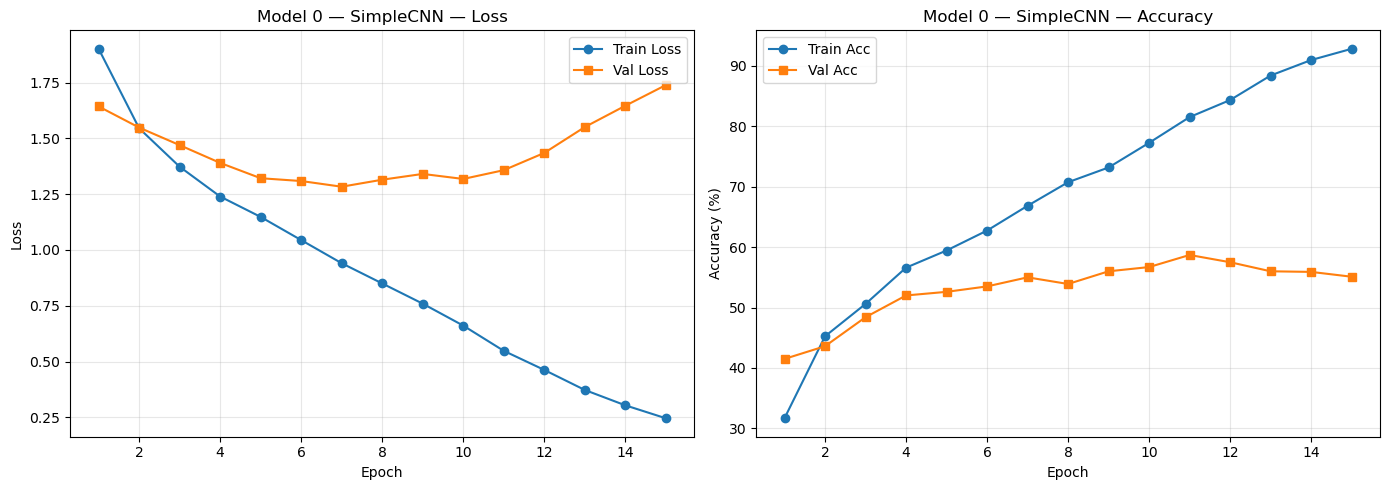

In [9]:
plot_history(history, title='Model 0 — SimpleCNN')

### 2.4 Results Summary

In [ ]:
final_train_acc = history['train_acc'][-1]
final_val_acc   = history['val_acc'][-1]
peak_val_acc    = max(history['val_acc'])
gap             = final_train_acc - final_val_acc

print('=' * 50)
print('         MODEL 0 — RESULTS SUMMARY')
print('=' * 50)
print(f'  Parameters       : {count_parameters(model):,}')
print(f'  Final Train Acc  : {final_train_acc:.2f}%')
print(f'  Final Val Acc    : {final_val_acc:.2f}%')
print(f'  Peak Val Acc     : {peak_val_acc:.2f}%')
print(f'  Train-Val Gap    : {gap:+.2f}%')
print(f'  Final Train Loss : {history["train_loss"][-1]:.4f}')
print(f'  Final Val Loss   : {history["val_loss"][-1]:.4f}')
print('=' * 50)

         MODEL 0 — RESULTS SUMMARY
  Parameters       : 268,650
  Final Train Acc  : 92.82%
  Final Val Acc    : 55.10%
  Peak Val Acc     : 58.70%
  Train–Val Gap    : +37.72%
  Final Train Loss : 0.2459
  Final Val Loss   : 1.7384
